GoRL 目标导向强化学习

* HER(hindsight experience replay)算法，事后经验回放

* 仅适用于异策略，因为主要改进在经验采样部分

# 如何理解HER算法

接下来看看如何实现 HER 算法。首先定义一个简单二维平面上的环境。在一个二维网格世界上，每个维度的位置范围是[0,5]，在每一个序列的初始，智能体都处于[0,0]的位置，环境将自动从3.5<=x, y<=4.5的矩形区域内生成一个目标。每个时刻智能体可以选择纵向和横向分别移动[-1,1]作为这一时刻的动作。当智能体距离目标足够近的时候，它将收到奖励并结束任务，否则奖励为-1。每一条序列的最大长度为 50。

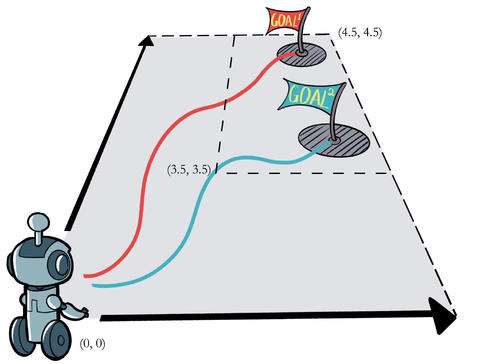

个人理解是，经验池改成储存轨迹，在轨迹上采样，并且有比较大的概率把负奖励改成0，或者把0改成正奖励，从而提高经验利用效率

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt


class WorldEnv:
    def __init__(self):
        self.distance_threshold = 0.15
        self.action_bound = 1

    def reset(self):  # 重置环境
        # 初始状态随机生成一个真目标状态, 从[3.5 ~ 4.5, 3.5 ~ 4.5]中随机取
        self.goal = np.array([4 + random.uniform(-0.5, 0.5), 4 + random.uniform(-0.5, 0.5)])
        self.state = np.array([0, 0])  # 初始状态
        self.count = 0
        return np.hstack((self.state, self.goal))

    def step(self, action:list):
        '''
        动作包含两个值，x、y两个方向移动量，限制在-1~1
        '''
        action = np.clip(action, -self.action_bound, self.action_bound)
        x = max(0, min(5, self.state[0] + action[0]))  # 新状态限制在0~5
        y = max(0, min(5, self.state[1] + action[1]))
        self.state = np.array([x, y])
        self.count += 1

        dis = np.sqrt(np.sum(np.square(self.state - self.goal)))  # 和真目标的距离
        reward = -1.0 if dis > self.distance_threshold else 0
        if dis <= self.distance_threshold or self.count == 50:  # 最多50步
            done = True
        else:
            done = False

        return np.hstack((self.state, self.goal)), reward, done  # * 注意state设计，同时给了 “当前位置” 和 “目标位置”

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return torch.tanh(self.fc3(x)) * self.action_bound


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc2(F.relu(self.fc1(cat))))
        return self.fc3(x)

# DDPG

在定义好 Actor 和 Critic 的网络结构之后，来看一下 DDPG 算法的代码。之前的 DDPG 算法是在倒立摆环境中运行的，动作只有 1 维，而这里的环境中动作有 2 维，导致选择动作函数用的是detach分离action出计算图，而不是item

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, sigma, tau, gamma, device):
        self.action_dim = action_dim
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并使其参数和价值网络一样
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并使其参数和策略网络一样
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_bound = action_bound
        self.device = device

    def take_action(self, state):
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        action = self.actor(state).detach().cpu().numpy()[0]  # * 动作是数组, 用.detach()把action分离出计算图
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.int).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones | truncated)
        # MSE损失函数
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 策略网络就是为了使Q值最大化
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

# 轨迹经验池

接下来定义一个特殊的经验回放池，此时回放池内不再存储每一步的数据，而是存储一整条轨迹。这是 HER 算法中的核心部分，之后可以用 HER 算法从该经验回放池中构建新的数据来帮助策略训练。

In [4]:
class Trajectory:
    ''' 用来记录一条完整轨迹 '''
    def __init__(self, init_state):
        self.states = [init_state]
        self.actions = []
        self.rewards = []
        self.dones = []
        self.length = 0

    def store_step(self, action, state, reward, done):
        self.actions.append(action)
        self.states.append(state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.length += 1


class ReplayBuffer_Trajectory:
    ''' 存储轨迹的经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add_trajectory(self, trajectory):
        self.buffer.append(trajectory)  # 一次存一整个轨迹

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size, use_her, dis_threshold=0.15, her_ratio=0.8):
        batch = dict(states=[],
                     actions=[],
                     next_states=[],
                     rewards=[],
                     dones=[])
        for _ in range(batch_size):
            traj = random.sample(self.buffer, 1)[0]  # 随机从self.buffer中抽1个轨迹并取出
            step_state = np.random.randint(traj.length)  # 从轨迹中取某个时点
            state = traj.states[step_state]
            next_state = traj.states[step_state + 1]
            action = traj.actions[step_state]
            reward = traj.rewards[step_state]
            done = traj.dones[step_state]
            
            # 如果使用HER，在0.8的概率下执行
            if use_her and np.random.uniform() <= her_ratio:
                # 从step_state + 1, traj.length + 1中均匀取一个数, 作为新的目标的索引, 注意与环境内的真实目标区分
                step_goal = np.random.randint(step_state + 1, traj.length + 1)
                # 使用HER算法的future方案, 在当前轨迹随机取一个点, 设置目标状态, 状态前两个值是坐标值
                goal = traj.states[step_goal][:2]
                dis = np.sqrt(np.sum(np.square(next_state[:2] - goal)))  # 计算下一个状态位置和目标值的距离
                reward = -1.0 if dis > dis_threshold else 0  # 如果下一状态离目标比较近, 不惩罚
                done = False if dis > dis_threshold else True  # 如果下一状态离目标比较近, 结束
                state = np.hstack((state[:2], goal))  # 更新state中的goal
                next_state = np.hstack((next_state[:2], goal))  # 更新next_state中的goal
                
            batch['states'].append(state)
            batch['next_states'].append(next_state)
            batch['actions'].append(action)
            batch['rewards'].append(reward)
            batch['dones'].append(done)

        batch['states'] = np.array(batch['states'])
        batch['next_states'] = np.array(batch['next_states'])
        batch['actions'] = np.array(batch['actions'])
        return batch

# 模型训练

In [5]:
actor_lr = 1e-3
critic_lr = 1e-3
hidden_dim = 128
state_dim = 4
action_dim = 2
action_bound = 1
sigma = 0.1
tau = 0.005
gamma = 0.98
num_episodes = 200
iteration = 10
n_train = 20
batch_size = 256
minimal_episodes = 200
buffer_size = 10000  # 经验长度
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(iteration):
    with tqdm(total=int(num_episodes), desc=f'{i+1}/{iteration}', leave=False) as pbar:
        for i_episode in range(int(num_episodes)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)  # 记录轨迹
            replay_buffer.add_trajectory(traj)  # 保存一整条轨迹
            return_list.append(episode_return)  # 记录episode奖励
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):  # 更新n次(20次)
                    transition_dict = replay_buffer.sample(batch_size, True)  # 改成False为普通采样，效果很差
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes * i + i_episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

cuda


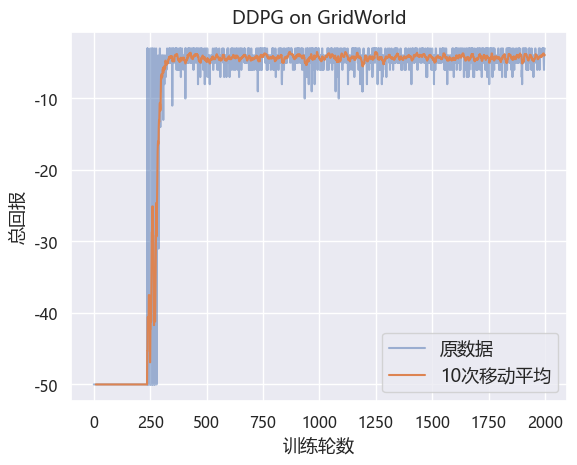

In [6]:
import rl_utils

rl_utils.picture_return(return_list, 'DDPG', 'GridWorld')

# 重要发现

对于DDPG算法中的take_action函数
```
def take_action(self, state):
    state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
    action = self.actor(state).detach().cpu().numpy()[0]  # * 动作是数组, 用.detach()把action分离出计算图
    # 给动作添加噪声，增加探索
    action = action + self.sigma * np.random.randn(self.action_dim)
    return action
```


第二行中，`state`需要是二维才能传入网络中计算，原本是一维，所以要多加一个维度，即`array([list])`变成`[[list]]`或`array([[list]])`，在原本的[教学代码](https://hrl.boyuai.com/chapter/3/%E7%9B%AE%E6%A0%87%E5%AF%BC%E5%90%91%E7%9A%84%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0)中，写为`[state]`，虽然效果一致，但是会告警：建议先转成`ndarray`。

因此在前面一些代码中，如PPO中，我写的是`np.array(state)`，其实这是错误的，因为没有加上新维度，但一直没有出现太大问题，但是在本节代码中发现，写为`np.array(state)`导致收敛效果很差，但是如果写作`state[np.newaxis, :]`，既不会告警，又能保证收敛效果好，***因此决定修改所有相关部分***。